In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("Dates")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Distances")
# Pkg.add("Random")
# Pkg.add("Distributions")
# Pkg.add("Statistics")
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("GMT")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Colors")
# Pkg.add("ColorSchemes")
# Pkg.add("Fontconfig")
# Pkg.add("Leaflet")
# Pkg.add("GeoInterface")
# Pkg.add("GeoJSON")

In [2]:
using Plots
using Compose, Cairo, Fontconfig

In [105]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/out.jl")
include("./src/lagrange.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


In [4]:
trips, shapes = loadGTFS("..\\data\\Nanaimo-GTFS");
# trips, shapes = loadGTFS("..\\data\\Cranbrook-GTFS");

In [119]:
# subset = subsetGTFS(trips, 9, randomSeed = 12) # good example
# subset = subsetGTFS(trips, 10, randomSeed = 12) # good example
subset = subsetGTFS(trips, n = 100, randomSeed = 1); # good example for mapping
# subset = subsetGTFS(trips, 20; routes = [1, 2, 3, 5, 7, 14, 20], start_time = 8, stop_time = 12, randomSeed = 1)
# subset = subsetGTFS(trips; routes = [1, 15], start_time = 14, stop_time = 18, randomSeed = 1)
# subset = subsetGTFS(trips; n = 30, routes = [6, 15, 20, 30, 40], start_time = 8, stop_time = 12, randomSeed = 1)
# subset = subsetGTFS(trips; n = 50, start_time = 8, stop_time = 15, randomSeed = 1)
l = primaryDelays(subset; form = 0)
# l = primaryDelays(subset; form = 1, bbox = [(-123.94295, 49.17101), (-123.93926, 49.17101)], shapes = shapes) # 1
# l = primaryDelays(subset; form = 0, bbox = [(-123.94176, 49.16629), (-123.93987, 49.16477)], shapes = shapes) # 40
instance = VSPInstance(subset; l = l)
del_model = VSPModel(instance; numScenarios = 20, split = 1.0, randomSeed = 1, timeLimit = 60)
# # vsp_model_nonint = VSPModel(instance; multiObj = false)
mcf_model = MCFModel(instance)
del_solution = solve!(del_model; silent = false);
# # vsp_solution_nonint = solve!(vsp_model_nonint)
mcf_solution = solve!(mcf_model);

numTrips = 100
numVehicles = 13.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 5541.714056815622
solve_time(mod.model) = 30.97599983215332


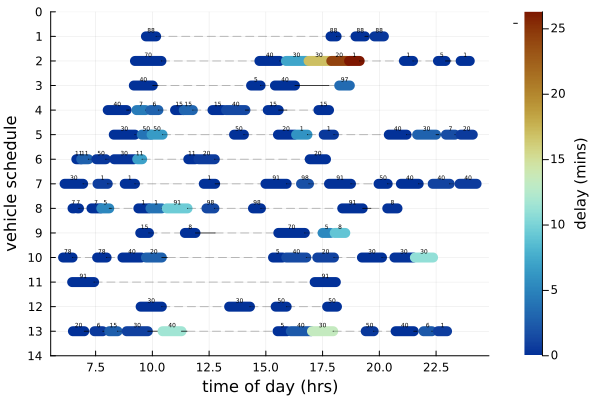

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [120]:
mcf_plot_time = plotVSP_time(mcf_solution; delays = del_model.L_train)
# savefig(mcf_plot_time, ".\\imgs\\VSP-time-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

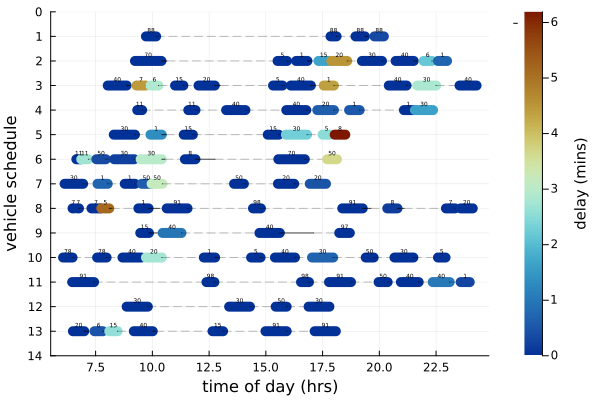

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [121]:
del_plot_time = plotVSP_time(del_solution; delays = del_model.L_train)
# savefig(del_plot_time, ".\\imgs\\VSP-PD-time-$(del_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

In [18]:
@show getSolutionStats(del_solution, shapes, del_model.L_train).μ
@show getSolutionStats(del_solution, shapes, del_model.L_test).μ;

(getSolutionStats(del_solution, shapes, del_model.L_train)).μ = 3.22544144247325
(getSolutionStats(del_solution, shapes, del_model.L_test)).μ = 3.1330357994413593


In [43]:
del_solution.objective_value/mcf_solution.objective_value

1.0219428887905293

In [12]:
# mcf_stats[:, Not("geometry")]
describe(mcf_stats[:, Not("geometry")])
# CSV.write(".\\data\\metrics\\VSP-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1-adjacent.csv", mcf_stats[:, Not("geometry")])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Union…,Real,Int64,DataType
1,duration,2.19048,0.333333,3.1,3.9,0,Float64
2,num_trips,4.0,1,6.0,7,0,Int64
3,utilization,0.82521,0.649214,0.747863,1.0,0,Float64
4,propagated_delay,0.00873193,0.0,0.0049663,0.0238892,0,Float64
5,propagated_delay_err,NaN,NaN,,NaN,0,Float64
6,trip_distance,42.5201,8.717,54.696,82.952,0,Float64
7,deadhead_distance,0.000568397,0.0,0.0,0.00153391,0,Float64


In [13]:
# del_stats[:, Not("geometry")]
describe(del_stats[:, Not("geometry")])
# CSV.write(".\\data\\metrics\\VSP-PD-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1-adjacent.csv", del_stats[:, Not("geometry")])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Union…,Real,Int64,DataType
1,duration,2.19048,0.333333,3.1,3.9,0,Float64
2,num_trips,4.0,1,6.0,7,0,Int64
3,utilization,0.82521,0.649214,0.747863,1.0,0,Float64
4,propagated_delay,0.00873193,0.0,0.0049663,0.0238892,0,Float64
5,propagated_delay_err,NaN,NaN,,NaN,0,Float64
6,trip_distance,42.5201,8.717,54.696,82.952,0,Float64
7,deadhead_distance,0.000568397,0.0,0.0,0.00153391,0,Float64


## Leaflet

In [7]:
m = plotVSP_map(del_stats; schedule = nothing)

Leaflet.Map{Vector{Leaflet.Layer}, Leaflet.Config{Leaflet.Provider}, WebIO.Scope}(Leaflet.Layer[Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05336, 49.23695], [-124.05365, 49.23715], [-124.05339, 49.23795], [-124.05296, 49.23823], [-124.05347, 49.23854], [-124.05402, 49.23871], [-124.05475, 49.2388], [-124.05422, 49.24012], [-124.05394, 49.24083], [-124.05388, 49.24176]  …  [-123.93352, 49.16575], [-123.93308, 49.16589], [-123.93274, 49.16589], [-123.93219, 49.16566], [-123.93175, 49.16528], [-123.93149, 49.16523], [-123.93133, 49.16508], [-123.93125, 49.16481], [-123.93136, 49.16462], [-123.93233, 49.16385]], nothing, nothing), Dict{Symbol, Any}(:color => "#1F77B4", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93232727050781, 49.163848876953125], [-123.93232727050781, 49.163848876953125]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93233, 49.16385], [-123.93291, 49.16314], [-123.93319, 49.16321], [-123.93478, 49.16299], [-123.93517, 49.16331], [-123.93592, 49.16358], [-123.93638, 49.16365], [-123.93704, 49.16409], [-123.93825, 49.16463], [-123.94002, 49.16588]  …  [-124.05347, 49.23854], [-124.05296, 49.23823], [-124.05339, 49.23795], [-124.05366, 49.23726], [-124.05353, 49.23701], [-124.05327, 49.23685], [-124.05366, 49.2366], [-124.05296, 49.23615], [-124.05253, 49.23632], [-124.05299, 49.23674]], nothing, nothing), Dict{Symbol, Any}(:color => "#1F77B4", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05299377441406, 49.23674011230469], [-124.05335998535156, 49.2369499206543]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05336, 49.23695], [-124.05365, 49.23715], [-124.05339, 49.23795], [-124.05296, 49.23823], [-124.05347, 49.23854], [-124.05402, 49.23871], [-124.05475, 49.2388], [-124.05422, 49.24012], [-124.05394, 49.24083], [-124.05388, 49.24176]  …  [-123.93638, 49.16365], [-123.93598, 49.16352], [-123.93574, 49.1634], [-123.93546, 49.16342], [-123.93517, 49.16331], [-123.93478, 49.16299], [-123.93319, 49.16321], [-123.93291, 49.16314], [-123.93208, 49.1639], [-123.93158, 49.16426]], nothing, nothing), Dict{Symbol, Any}(:color => "#1F77B4", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93157958984375, 49.16426086425781], [-123.93157958984375, 49.16426086425781]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, fa

## Scenario comparison

In [77]:
num_sols = []
similarity = []
train_delay = []
test_delay = []
numSeeds = 20

for n in 10:10:100
    sols = []
    unique_sols = []
    similarity_mcf = []
    subset = subsetGTFS(trips; n = n, randomSeed = 1)
    l = primaryDelays(subset; form = 0)
    instance = VSPInstance(subset; l = l)
    mcf_model = MCFModel(instance)
    mcf_solution = solve!(mcf_model)

    for seed in 1:numSeeds
        del_model = VSPModel(instance; numScenarios = 10, split = 1.0, randomSeed = seed, warmStart = mcf_solution, timeLimit = 60)
        del_solution = solve!(del_model)
        push!(sols, del_solution)
        if isempty(unique_sols)
            push!(unique_sols, del_solution)
        else
            unique = true
            for sol in unique_sols
                if compareSchedules(sol, del_solution) == 1
                    unique = false
                end
            end
            if unique
                push!(unique_sols, del_solution)
            end
        end
        push!(similarity_mcf, compareSchedules(del_solution, mcf_solution))
    end

    train = []
    test = []
    for i in 1:numSeeds
        for j in 1:numSeeds
            if i == j
                push!(train, getSolutionStats(sols[i], shapes, sols[i].mod.L_train).μ)
            else
                push!(test, getSolutionStats(sols[i], shapes, sols[j].mod.L_train).μ)
            end
        end
    end

    push!(num_sols, length(unique_sols)/numSeeds)
    push!(similarity, mean(similarity_mcf))
    push!(train_delay, mean(train))
    push!(test_delay, mean(test))
end

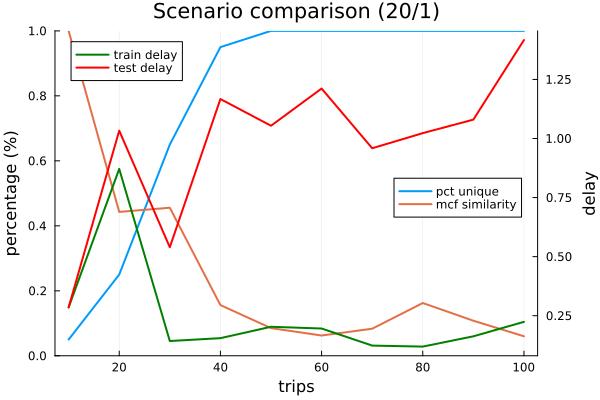

In [76]:
scenario_comparison_plot = plot(
    10:10:100,
    [num_sols similarity],
    label=["pct unique" "mcf similarity"],
    lw=2,
    xlabel="trips",
    ylabel="percentage (%)",
    ylims=[0, 1],
    title="Scenario comparison (20/1)",
    legend=:right
)
plot!(
    twinx(scenario_comparison_plot),
    10:10:100,
    [train_delay test_delay],
    label=["train delay" "test delay"],
    lw=2,
    color=[:green :red],
    ylabel="delay"
)
# savefig(scenario_comparison_plot, ".\\imgs\\VSP-PD-100-20_1-scenario_comparison.png")

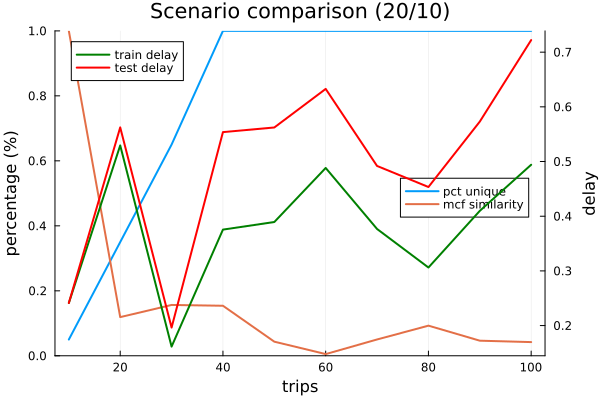

In [80]:
scenario_comparison_plot = plot(
    10:10:100,
    [num_sols similarity],
    label=["pct unique" "mcf similarity"],
    lw=2,
    xlabel="trips",
    ylabel="percentage (%)",
    ylims=[0, 1],
    title="Scenario comparison (20/10)",
    legend=:right
)
plot!(
    twinx(scenario_comparison_plot),
    10:10:100,
    [train_delay test_delay],
    label=["train delay" "test delay"],
    lw=2,
    color=[:green :red],
    ylabel="delay"
)
# savefig(scenario_comparison_plot, ".\\imgs\\VSP-PD-100-20_10-scenario_comparison.png")

## Spectrum of delay

In [129]:
del_delay = []
del_std = []
mcf_delay = []
mcf_std = []
similarity = []

let
    subset = subsetGTFS(trips; n = 50, randomSeed = 1)
    instance = VSPInstance(subset)
    mcf_model = MCFModel(instance)
    mcf_solution = solve!(mcf_model)
    for std_multi in 0.1:0.1:1.0
        l = primaryDelays(subset; form = 0, stdMulti = std_multi)
        instance = VSPInstance(subset; l = l)
        del_model = VSPModel(instance; numScenarios = 20, split = 1.0, randomSeed = 1, warmStart = mcf_solution, timeLimit = 60)
        del_solution = solve!(del_model)
        del_stats = getSolutionStats(del_solution, shapes, del_model.L_train)
        mcf_stats = getSolutionStats(mcf_solution, shapes, del_model.L_train)
        push!(del_delay, del_stats.μ)
        push!(del_std, del_stats.σ)
        push!(mcf_delay, mcf_stats.μ)
        push!(mcf_std, mcf_stats.σ)
        push!(similarity, compareSchedules(del_solution, mcf_solution))
    end
end

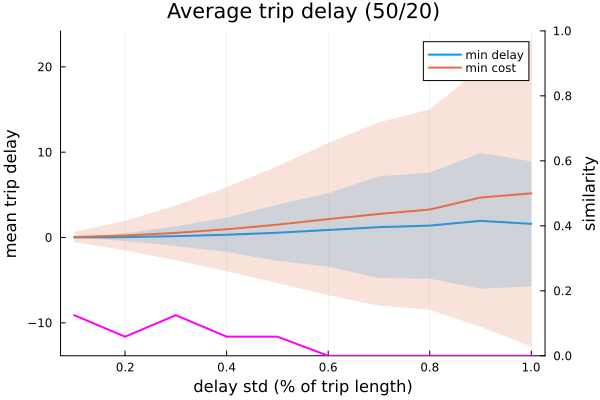

In [133]:
del_spectrum_plot = plot(
    0.1:0.1:1.0,
    [del_delay mcf_delay],
    ribbon=[del_std mcf_std],
    label=["min delay" "min cost"],
    lw=2,
    fillalpha=0.2,
    xlabel="delay std (% of trip length)",
    ylabel="mean trip delay",
    title="Average trip delay (50/20)",
    legend=:topright
)
plot!(
    twinx(del_spectrum_plot),
    0.1:0.1:1.0,
    similarity,
    ylims=[0, 1],
    label="",
    lw=2,
    color=:magenta,
    ylabel="similarity"
)
# savefig(del_spectrum_plot, ".\\imgs\\VSP-PD-50-20-std_spectrum.png")

## Train/test split

In [88]:
train_delay = []
train_std = []
test_delay = []
test_std = []
similarity = []
test_μ = 0.0

let
    subset = subsetGTFS(trips; n = 100, randomSeed = 1)
    # subset = subsetGTFS(trips; n = 50, start_time = 0, stop_time = 15, randomSeed = 1)
    l = primaryDelays(subset; form = 0, stdMulti = 1.0)
    instance = VSPInstance(subset; l = l)
    full_model = VSPModel(instance; numScenarios = 10, split = 1.0, randomSeed = 2, timeLimit = 60)
    full_solution = solve!(full_model)
    @show termination_status(full_solution.mod.model)
    test_μ = getSolutionStats(full_solution, shapes, full_model.L_train).μ
    for numScenarios in 1:10
        model = VSPModel(instance; warmStart = full_solution, numScenarios = numScenarios, split = 1.0, timeLimit = 60)
        solution = solve!(model)
        @show termination_status(solution.mod.model)
        train_stats = getSolutionStats(solution, shapes, model.L_train)
        test_stats = getSolutionStats(solution, shapes, full_model.L_train)
        push!(train_delay, train_stats.μ_10)
        push!(train_std, train_stats.σ_10)
        push!(test_delay, test_stats.μ_10)
        push!(test_std, test_stats.σ_10)
        push!(similarity, compareSchedules(solution, full_solution))
    end
end

termination_status(full_solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL
termination_status(solution.mod.model) = MathOptInterface.OPTIMAL


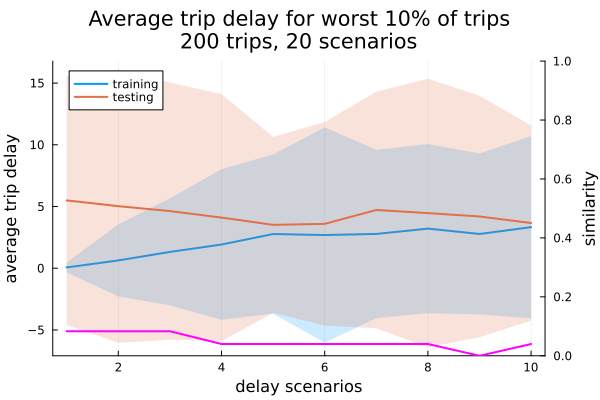

In [89]:
train_test_plot = plot(
    1:10,
    [train_delay test_delay],
    ribbon=[train_std test_std],
    label=["training" "testing"],
    lw=2,
    fillalpha=0.2,
    xlabel="delay scenarios",
    ylabel="average trip delay",
    title="Average trip delay for worst 10% of trips\n200 trips, 20 scenarios\n",
    legend=:topleft
)
plot!(
    twinx(train_test_plot),
    1:10,
    similarity,
    label="",
    lw=2,
    color=:magenta,
    ylabel="similarity",
    ylims=[0, 1]
)
# savefig(train_test_plot, ".\\imgs\\VSP-PD-200-20-train_test_curves.png")

## Bender's decomposition

In [9]:
# fs = FirstStageProblem(instance; timeLimit = 10)
# add_benders_callback!(fs)
# bd_solution = solve!(fs);
# @show mean(lp_callback_runtimes)
# @show mean(get_p_callback_runtimes);
# MOI.get(fs.model, MOI.RelativeGap())
# plotVSP(bd_solution)

## 10 sec opt gap

In [11]:
# instance_sizes = 100:100:500
# opt_gap_IP = []
# opt_gap_BD = []

# for size in instance_sizes
#     sum_IP = 0
#     sum_BD = 0
#     for i in 1:5
#         subset = subsetGTFS(trips, size, randomSeed = i)
#         instance = VSPInstance(subset)
#         model_IP = VSPModel(instance, isInt = true, multiObj = false, timeLimit = 10)
#         model_BD = FirstStageProblem(instance, timeLimit = 10)
#         add_benders_callback!(model_BD)
#         sol_IP = solve!(model_IP);
#         sol_BD = solve!(model_BD);
#         sum_IP += MOI.get(model_IP.model, MOI.RelativeGap())
#         sum_BD += MOI.get(model_BD.model, MOI.RelativeGap())
#     end
#     push!(opt_gap_IP, sum_IP / 5)
#     push!(opt_gap_BD, sum_BD / 5)
# end
@show [opt_gap_IP opt_gap_BD]

[opt_gap_IP opt_gap_BD] = [6.031947682607448e-6 0.1629275916113045; 0.027256919099971622 0.47132052625010956; 0.526180825699331 0.768839649480148; 0.7067324202226736 0.8463141117589137]


4×2 Matrix{Float64}:
 6.03195e-6  0.162928
 0.0272569   0.471321
 0.526181    0.76884
 0.706732    0.846314

## Lagrange relaxation

In [51]:
LR = LagrangeRelaxation(instance)

for i ∈ 1:100
    status = update!(LR)
    if status
        println(i)
        break
    end
end

Solution found within 1% optimality gap.
3


In [60]:
# plot([LR.UB LR.LB])
# hline!([objectiveValue(vsp_solution.x, vsp_solution.s, instance.C, instance.M)])
# plot(LR.opt_gap, ylims = [0, 1])
# LR.λ
# println(
#     "vsp: ",
#     sum(LR.x[LR.best_idx[1]] .+ vsp_solution.x .> 1) / sum(vsp_solution.x),
#     "; mcf: ",
#     sum(LR.x[LR.best_idx[1]] .+ mcf_solution.x .> 1) / sum(mcf_solution.x)
# )
# (minimum(LR.UB) .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# (LR.UB[1] .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# LR.s_adj
# plotVSP(instance, LR.x[LR.best_idx[1]], LR.s_adj[LR.best_idx[1]])

## solve times

In [8]:
# solve times
# instance_sizes = 20:20:200
# sol_times_LP = []
# sol_times_IP = []
# sol_times_BD = []

# for size in instance_sizes
#     sum_LP = 0
#     sum_IP = 0
    # sum_BD = 0
    # for i in 1:5
    #     subset = subsetGTFS(trips, size, randomSeed = i)
    #     instance = VSPInstance(subset)
    #     model_LP = VSPModel(instance, isInt = false, multiObj = false)
    #     model_IP = VSPModel(instance, isInt = true, multiObj = false)
        # model_BD = FirstStageProblem(instance)
        # add_benders_callback!(model_BD)
        # sol_LP = solve!(model_LP);
        # sol_IP = solve!(model_IP);
        # sol_BD = solve!(model_BD);
        # sum_LP += sol_LP.solve_time
        # sum_IP += sol_IP.solve_time
        # sum_BD += sol_BD.solve_time
    # end
    # push!(sol_times_LP, sum_LP / 5)
    # push!(sol_times_IP, sum_IP / 5)
    # push!(sol_times_BD, sum_BD / 5)
# end
# plot(
#     instance_sizes,
#     [sol_times_LP sol_times_IP];
#     xlabel = "number of trips",
#     ylabel = "solve time",
#     title = "LP, and IP solution times",
#     label = ["LP" "IP"]
# )
# png(".\\imgs\\VSP-PD-solve_times-BD")

## Pareto frontier

In [94]:
# Pareto frontier
# mod = del_model.model
# used_vehicles = [round(sum(value.(del_model.x[1, :]; result = i)); digits = 3) for i in 1:result_count(mod)]
# ideal_point = objective_bound(mod)
# pareto_plot = hline([ideal_point[2]]; color = :red, lw = 2, label = "", ylims = [1000, 2000], xlims = [-0.2, 7])
# vline!([ideal_point[1]]; color = :red, lw = 2, label = "objective bounds")
# Plots.scatter!(
#     [objective_value(mod; result = i)[1] for i in 1:result_count(mod)],
#     [objective_value(mod; result = i)[2] for i in 1:result_count(mod)];
#     xlabel = "delay",
#     ylabel = "cost",
#     title = "# trips: $(instance.n-1)",
#     label = "fleet used",
# )
# for i in 1:result_count(mod)
#     y = objective_value(mod; result = i)
#     Plots.annotate!(y[1], y[2] + 10, (used_vehicles[i], 10))
# end
# png(".\\imgs\\VSP-PD-$(instance.n-1)-pareto")
# pareto_plot